# Chapter 2: A real example. Importing data and setting series

## Data Management


In this example we will show how we can import data from a csv and generate a model with several depositional series.

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_9lf8symw.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1050 Ti (0000:01:00.0)


In this case instead loading a geo_data object directly, we will create one. The main atributes we need to pass are:
- Extent: X min, X max, Y min, Y max, Z min, Z max
- Resolution: X,Y,Z

Additionaly we can pass the address to csv files (GeoModeller3D format) with the data.

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000,747000,6863000,6930000,-20000, 200],[100, 100, 100],
                         path_o = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

You can visualize the points in 3D (work in progress)

Or a projection in 2D:

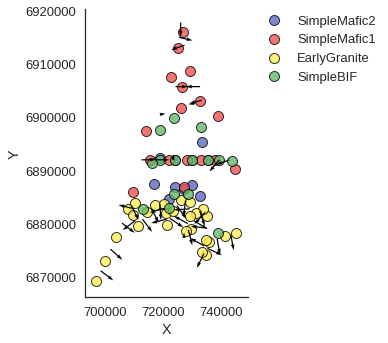

In [3]:
import matplotlib.pyplot as plt
gp.plot_data(geo_data, direction='z')


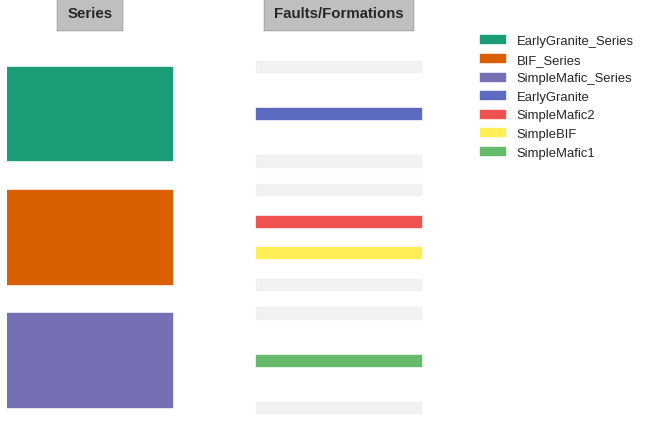

In [4]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                         "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

## Computing the model

Now as in the previous chapter we just need to create the interpolator object and compute the model.

In [5]:
interp_data = gp.InterpolatorData(geo_data, theano_optimizer='fast_run', compile_theano=True)

Compiling theano function...


/home/miguel/anaconda3/lib/python3.6/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')


Scan removed 1 0 scanOp_pushout_seqs_ops for{cpu,scan_fn}.0 Elemwise{mul,no_inplace}.0


/home/miguel/anaconda3/lib/python3.6/site-packages/theano/gpuarray/linalg.py:119: UserWarning: The GpuSolve op requires scikit-cuda > 0.5.1 to work with CUDA 8
  warnings.warn('The GpuSolve op requires scikit-cuda > 0.5.1 to work with CUDA 8')


Compilation Done!
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32


/home/miguel/anaconda3/lib/python3.6/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
  'CVM does not support memory profile, using Stack VM.')


In [6]:
# new_grid = gp.GridClass()
# res = 50

# # Create a new grid object with the new resolution
# new_grid.create_regular_grid_3d(geo_data.extent,[res, res, res])

# # Setting the new grid to the geodata
# gp.set_grid(geo_data, new_grid)

# interp_data.update_interpolator(geo_data)

In [8]:

lith_block, fault_block = gp.compute_model(interp_data)

In [10]:
lith_block

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 10.26072121,  10.26392841,  10.26713467, ...,  10.09634972,
         10.09873009,  10.10121918]], dtype=float32)

In [9]:
interp_data.th_fn.profile.summary()

Function profiling
  Message: ../../gempy/interpolator.py:124
  Time in 1 calls to Function.__call__: 7.849388e-01s
  Time in Function.fn.__call__: 7.848473e-01s (99.988%)
  Time in thunks: 7.808781e-01s (99.483%)
  Total compile time: 8.376535e+01s
    Number of Apply nodes: 201
    Theano Optimizer time: 3.178091e+01s
       Theano validate time: 4.960132e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 5.194658e+01s
       Import time 2.018352e-01s
       Node make_thunk time 5.193778e+01s
           Node forall_inplace,gpu,Looping interfaces}(Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64


Timing Info
-----------
--> <time> <% time> - <total time> <% total time>'

<time>         computation time for this node
<% time>       fraction of total computation time for this node
<total time>   time for this node + total times for this node's ancestors
<% total time> total time for this node over total computation time

N.B.:
* Times include the node time and the function overhead.
* <total time> and <% total time> may over-count computation times
  if inputs to a node share a common ancestor and should be viewed as a
  loose upper bound. Their intended use is to help rule out potential nodes
  to remove when optimizing a graph because their <total time> is very low.

HostFromGpu(gpuarray) [id A] <TensorType(float32, matrix)> ''   200 --> 3.32e-03s  0.4% 8.03e-01s 102.4%
 |GpuSubtensor{int64, ::, :int64:} [id B] <GpuArrayType<None>(float32, matrix)> ''   198 --> 3.58e-06s  0.0% 8.00e-01s 101.9%
   |forall_inplace,gpu,Looping interfaces}.0 [id C] <GpuArrayType<None>(float32, 3D)

Memory Profile
(Sparse variables are ignored)
(For values in brackets, it's for linker = c|py
---
    Max peak memory with current setting
        CPU: 7813KB (7813KB)
        GPU: 74230KB (74230KB)
        CPU + GPU: 82042KB (82042KB)
    Max peak memory with current setting and Theano flag optimizer_excluding=inplace
        CPU: 7813KB (7813KB)
        GPU: 89857KB (89857KB)
        CPU + GPU: 97669KB (97669KB)
    Max peak memory if allow_gc=False (linker don't make a difference)
        CPU: 7813KB
        GPU: 85965KB
        CPU + GPU: 93778KB
---

    <Sum apply outputs (bytes)> <Apply outputs shape> <created/inplace/view> <Apply node>

      36004752B  [(9, 1000132)] c GpuJoin(TensorConstant{1}, GpuReshape{2}.0, InplaceGpuDimShuffle{1,0}.0)
      36000000B  [(9, 1000000)] v GpuReshape{2}(<GpuArrayType<None>(float32, matrix)>, TensorConstant{[ 9 -1]})
      16002160B  [(2, 2, 1000132), (3, 4)] i c forall_inplace,gpu,Looping interfaces}(Elemwise{Composite{minimum(minimum(minimum

In [24]:
lith_block[1].min()

-50.072498

In [25]:
interp_data.potential_at_interfaces

array([[ 25.07173729,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.54429376,   0.53983349,   0.        ],
       [  0.        ,   0.        ,   0.        , -49.38788986]], dtype=float32)

Now if we analyse the results we have a 3D array where the axis 0 represent the superposition of the series (potential fields). The color coding is working process yet.

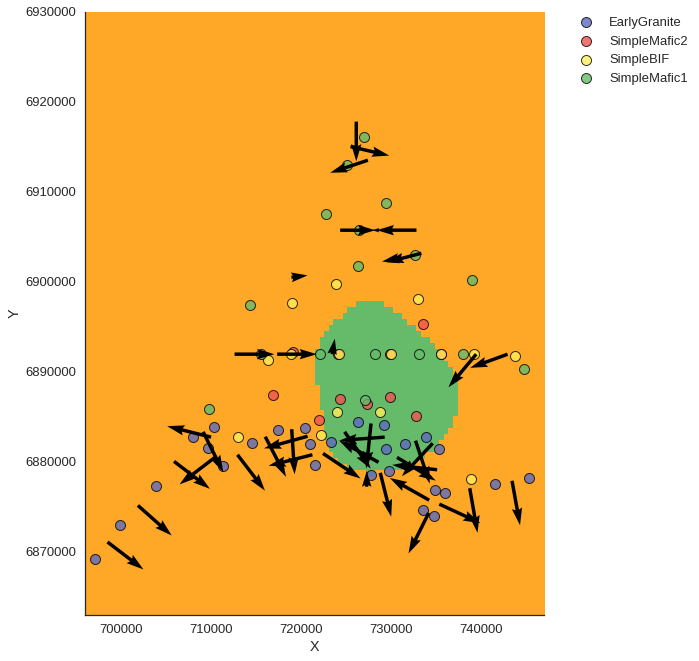

In [12]:
import matplotlib.pyplot as plt

gp.plot_section(geo_data, lith_block[0], -1, plot_data=True, direction='z')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

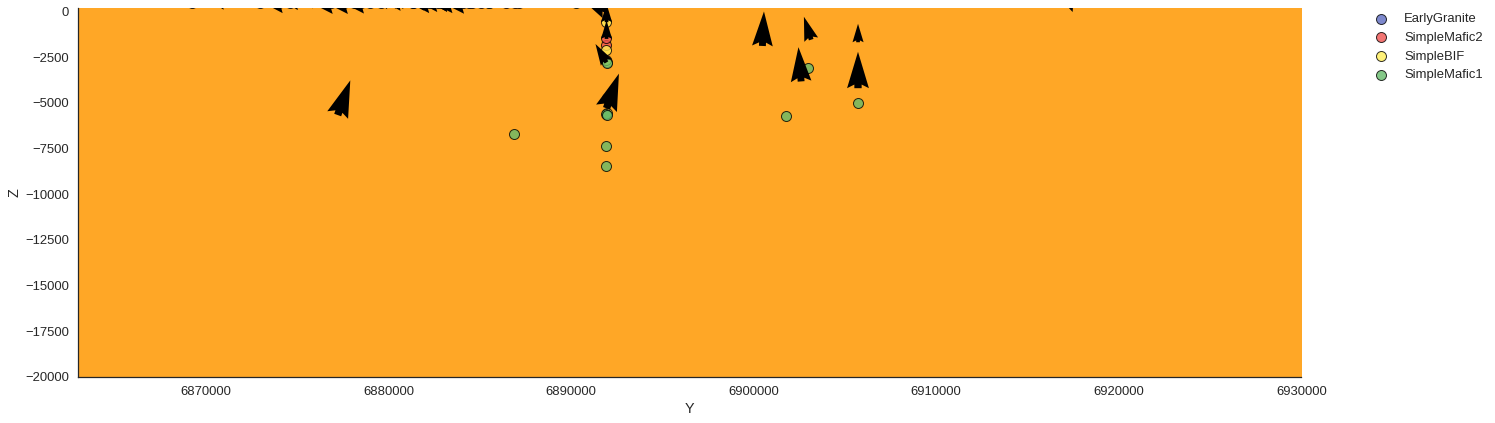

In [11]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0],25, plot_data=True, direction='x')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

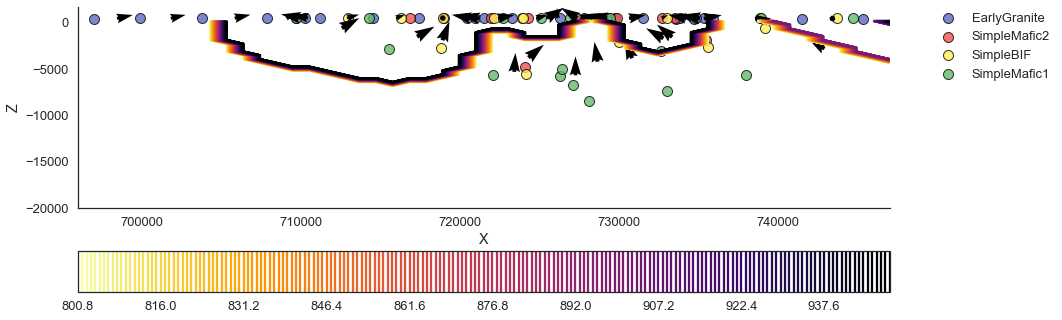

In [14]:
gp.plot_scalar_field(geo_data, lith_block[1], 11, cmap='inferno_r', N=200)
import matplotlib.pyplot as plt
plt.colorbar(orientation='horizontal')

And the axis 2 keeps the faults network that in this model since there is not faults does not represent anything.

Additionally with can export the blocks to vtk in order to visualize them in Paraview. We are working in visualization in place as well.

In [7]:
vertices, simplices = gp.get_surfaces(interp_data, lith_block[1], None, original_scale=False)

# np.save('ver_sand', vertices)
# np.save('sim_sand', simplices)

In [14]:
gp.export_to_vtk(geo_data, lith_block=lith_block[0], vertices=vertices, simplices=simplices)

In [10]:
gp.plot_surfaces_3D_real_time(interp_data, vertices, simplices, alpha=1)